<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Segmenta_dataset_coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask R-CNN - Segmentando imagens de posições físico humanas



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Projeto/outros/Mask_RCNN") ##This content is related to the github of mask R CNN, foi realizada um clone e se alterou o que foi necessário.

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
SAVE_SIT_DIR = os.path.join(ROOT_DIR, "mask_images/sitting")
SAVE_STAND_DIR = os.path.join(ROOT_DIR, "mask_images/standing")
SAVE_LYING_DIR = os.path.join(ROOT_DIR, "mask_images/lying")
LYING_DIR = os.path.join(ROOT_DIR, "test/lying")
SIT_DIR = os.path.join(ROOT_DIR, "test/sitting")
STAND_DIR = os.path.join(ROOT_DIR, "test/standing")


In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Cria o modelo e carrega o pré-treino


In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

2023-06-26 19:57:45.722734: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Instructions for updating:
box_ind is deprecated, use box_indices instead


2023-06-26 19:57:49.547978: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2023-06-26 19:57:49.567077: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2023-06-26 19:57:49.579807: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.


Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Use `tf.cast` instead.


2023-06-26 19:57:51.326653: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.


In [ ]:
# COCO Class names

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Detecção de classes - Exemplo


Processing 1 images
image                    shape: (470, 369, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


2023-06-26 19:57:53.660333: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -50 } dim { size: 256 } dim { size: 256 } dim { size: 256 } } } inputs { dtype: DT_FLOAT shape { dim { size: -19 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -19 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 7 } } device { type: "CPU" vendor: "AuthenticAMD" model: "248" frequency: 2096 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 8388608 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { d

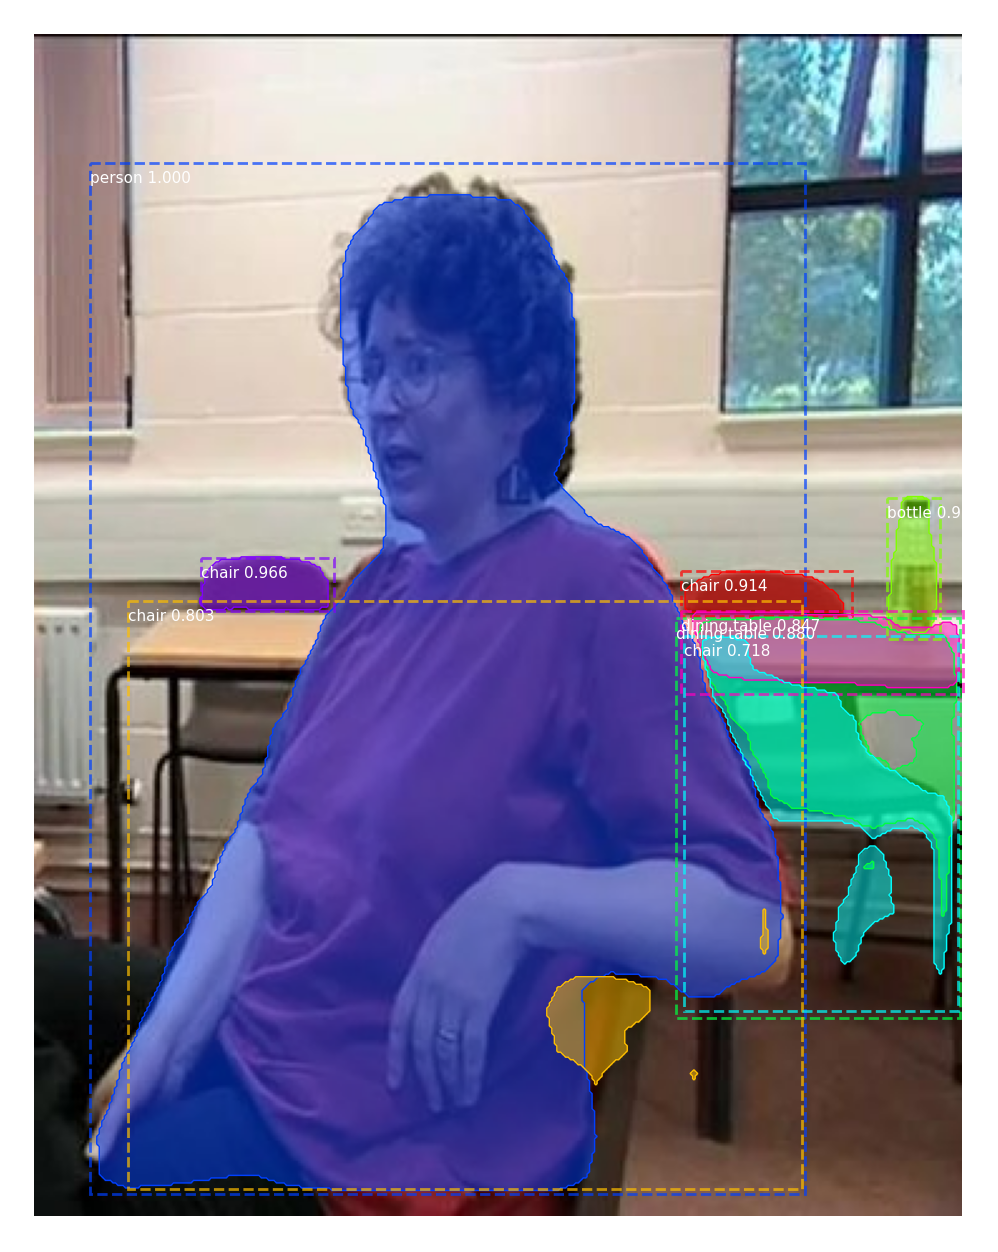

In [ ]:

sit_names = next(os.walk(SIT_DIR))[2]
image = skimage.io.imread(os.path.join(SIT_DIR, sit_names[10]))
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mask_for_class(image, masks, class_ids, class_names, class_id):
    class_indices = np.where(class_ids == class_id)[0]
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    for idx in class_indices:
        mask = np.logical_or(mask, masks[:, :, idx])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Mask for Class: ' + class_names[class_id])

    plt.tight_layout()
    plt.show()



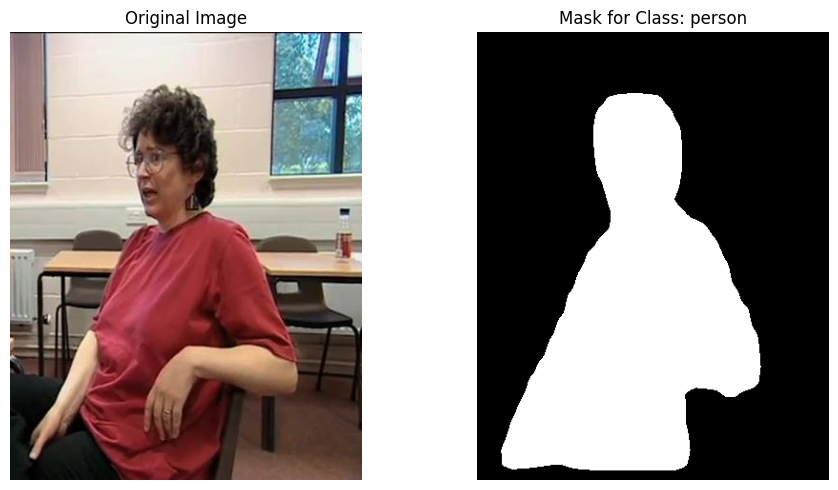

In [ ]:
plot_mask_for_class(image, r['masks'], r['class_ids'], class_names, class_id=1)

In [ ]:
import skimage.io
import os
import numpy as np

def save_masks_for_class(model, image_dir, class_id, save_dir):
    image_filenames = next(os.walk(image_dir))[2]

    for image_filename in image_filenames:
        # Carrega a imagem
        image_path = os.path.join(image_dir, image_filename)
        image = skimage.io.imread(image_path)

        # Detecção
        results = model.detect([image], verbose=1)

        # Pega os resultados
        r = results[0]
        masks = r['masks']
        rois = r['rois']
        class_ids = r['class_ids']

        class_indices = np.where(class_ids == class_id)[0]
        mask = np.zeros_like(masks[:, :, 0], dtype=np.uint8)
        for idx in class_indices:
            mask = np.logical_or(mask, masks[:, :, idx])

        # Salva a máscara da imagem atual
        original_filename = os.path.splitext(image_filename)[0]
        new_filename = f'mask_{original_filename}.png'
        save_path = os.path.join(save_dir, new_filename)

        skimage.io.imsave(save_path, np.uint8(mask) * 255)

In [ ]:
image_dir = SIT_DIR
class_id = 1
save_dir = SAVE_SIT_DIR

save_masks_for_class(model, image_dir, class_id, save_dir)

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 854, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

In [ ]:
image_dir = STAND_DIR
class_id = 1
save_dir = SAVE_STAND_DIR

save_masks_for_class(model, image_dir, class_id, save_dir)

Processing 1 images
image                    shape: (480, 854, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.1

In [ ]:
image_dir = LYING_DIR
class_id = 1
save_dir = SAVE_LYING_DIR

save_masks_for_class(model, image_dir, class_id, save_dir)

Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  124.3